***
El objetivo es resolver un problema de clasificación pasando por las siguientes etapas:

1. Carga de datos
2. Limpieza de datos
3. Separación en conjuntos de train y test
4. Feature Engineering
5. Entrenamiento de Modelos
6. Métricas

***

# Problema a Resolver

Les presentamos a la empresa “Frío Frío”, dedicada a la venta e instalación de equipos de aire acondicionado para grandes superficies. Al ser una empresa B2B (“Business To Business”), es esencial para ellos optimizar los esfuerzos de los representantes comerciales, ayudándolos a priorizar las oportunidades en el pipeline.

Una “oportunidad” consiste en un proyecto de venta o instalación de equipos para un cliente. La venta se estructura alrededor de TRF (Toneladas de refrigeración) y puede estar compuesta por varios productos distintos. El "pipeline" hace referencia al flujo de oportunidades prospecto que la empresa está desarrollando. El equipo comercial asigna a distintos momentos, para cada oportunidad, un estado en la negociación.

La variable que se está tratando de predecir es “Probabilidad de éxito” para cada oportunidad. ¿Cuál es la probabilidad de que la oportunidad se convierta en una venta? (el cual estará representado en la columna "Stage" como "Closed Won")
El dataset cuenta con información de cada oportunidad, como por ejemplo información sobre el vendedor a cargo de la venta, información geográfica de los clientes, fecha prevista de entrega de los equipos, etc. A partir de dichas variables es posible entrenar un modelo que prediga para un tiempo futuro el éxito o fracaso de cada oportunidad de venta. Idealmente, “Frío Frío” podrá usar este modelo para predecir la probabilidad de éxito de cada oportunidad comercial, para mejorar el rendimiento y optimizar el esfuerzo de los vendedores.


Los criterios de evaluación se detallan a continuación:
- Pertinencia: Que los contenidos expresados en la respuesta de las consignas correspondan claramente al tema central requerido en la misma.
-  Reproducibilidad: El notebook debe poder ser ejecutado de punta a punta sin errores. En caso contrario, no cumplirá el criterio de aprobación.
-  Conocimiento: Que el desarrollo de las consignas demuestre un sólido conocimiento del tema.
- Claridad en el código: Responde utilizando de forma concreta  y limitándose a escribir el código únicamente lo que se pregunta. Será penalizado el exceso de código.

In [506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [507]:
df = pd.read_csv('train.csv')
df = df[(df.Stage == 'Closed Won') | (df.Stage == 'Closed Lost')]
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,NaN,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,NaN,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


In [508]:
columnas_actuales = df.columns
columnas_normalizadas = [columna.lower().replace(' ', '').replace(',', '_').replace('(', '').replace(')', '') for columna in columnas_actuales]
df.rename(columns=dict(zip(columnas_actuales, columnas_normalizadas)), inplace=True)

### 1 - Chequear si los datos tienen nulos
Usar df.isna().sum()

In [509]:
print(df.isna().sum())

id                                       0
region                                   0
territory                             4981
pricing_delivery_terms_quote_appr        0
pricing_delivery_terms_approved          0
bureaucratic_code_0_approval             0
bureaucratic_code_0_approved             0
submitted_for_approval                   0
bureaucratic_code                        0
account_created_date                     0
source                                9454
billing_country                         27
account_name                             0
opportunity_name                         0
opportunity_id                           0
sales_contract_no                     6909
account_owner                            0
opportunity_owner                        0
account_type                           112
opportunity_type                         0
quote_type                               0
delivery_terms                           0
opportunity_created_date                 0
brand      

### 2 - Reemplazar los NaN (Nulos) 
Utilizar la funcion df.fillna()
Ayuda: las variables categoricas rellenarlas con la moda, las variables númericas con la media

In [510]:
# Rellenar valores nulos en variables categóricas con la moda
for columna in df.select_dtypes(include='object'):  # Seleccionar solo columnas categóricas
    df[columna].fillna(df[columna].mode()[0], inplace=True)

# Rellenar valores nulos en variables numéricas con la media
for columna in df.select_dtypes(include='number'):  # Seleccionar solo columnas numéricas
    df[columna].fillna(df[columna].mean(), inplace=True)

print(df.isna().sum())#revisamos si existen valores nulos otra vez.
df

id                                   0
region                               0
territory                            0
pricing_delivery_terms_quote_appr    0
pricing_delivery_terms_approved      0
bureaucratic_code_0_approval         0
bureaucratic_code_0_approved         0
submitted_for_approval               0
bureaucratic_code                    0
account_created_date                 0
source                               0
billing_country                      0
account_name                         0
opportunity_name                     0
opportunity_id                       0
sales_contract_no                    0
account_owner                        0
opportunity_owner                    0
account_type                         0
opportunity_type                     0
quote_type                           0
delivery_terms                       0
opportunity_created_date             0
brand                                0
product_type                         0
size                     

,id,region,territory,pricing_delivery_terms_quote_appr,pricing_delivery_terms_approved,bureaucratic_code_0_approval,bureaucratic_code_0_approved,submitted_for_approval,bureaucratic_code,account_created_date,...,delivery_quarter,delivery_year,actual_delivery_date,trf,total_amount_currency,total_amount,total_taxable_amount_currency,total_taxable_amount,stage,prod_category_a
0,27761,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,Germany,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


### 3 A - ¿Cual es la distribución del target (Stage)? (Proporcion de la clase positiva)


In [511]:
# Calcular la distribución del target (Stage)
distribucion = df['stage'].value_counts()

# Calcular la proporción de la clase positiva ("Closed Won")
proporcion_clase_positiva = distribucion['Closed Won'] / len(df) * 100

print("Distribución del target (stage):")
print(distribucion)
print("\nProporción de la clase positiva (Closed Won): {:.2f}%".format(proporcion_clase_positiva))

Distribución del target (stage):
Closed Won     9533
Closed Lost    7350
Name: stage, dtype: int64

Proporción de la clase positiva (Closed Won): 56.47%


### 3 B - Transformar el target en 0 y 1.

In [512]:
# Mapear la clase negativa ("Closed Lost") a 0 y la clase positiva ("Closed Won") a 1
df['stage'] = df['stage'].map({'Closed Lost': 0, 'Closed Won': 1})
df.head()  # Mostrar las primeras 5 filas del DataFrame

,id,region,territory,pricing_delivery_terms_quote_appr,pricing_delivery_terms_approved,bureaucratic_code_0_approval,bureaucratic_code_0_approved,submitted_for_approval,bureaucratic_code,account_created_date,...,delivery_quarter,delivery_year,actual_delivery_date,trf,total_amount_currency,total_amount,total_taxable_amount_currency,total_taxable_amount,stage,prod_category_a
0,27761,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,0,Prod_Category_A_None
1,27760,EMEA,Germany,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,1,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,1,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,0,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,0,Prod_Category_A_None


### 4- Separar en X e y

In [513]:
feature_cols = [col for col in df.columns if col not in [
    'id', 
    'stage' ,
    'territory', 
    'source', 
    'sales_contract_no', 
    'brand', 
    'product_type', 
    'size', 
    'product_category_b', 
    'price', 
    'currency', 
    'asp', 
    'asp_converted', 
    'account_created_date', 
    'account_name', 
    'opportunity_name', 
    'opportunity_created_date', 
    'quote_expiry_date',
    'last_modified_date', 
    'product_name', 
    'planned_delivery_start_date', 
    'planned_delivery_end_date', 
    'last_activity', 
    'asp_converted_currency', 
    'actual_delivery_date', 
    'prod_category_a' 
    ]]

In [514]:
# Variables independientes (X): Seleccionar las columnas de características
X = df[feature_cols]

# Variable dependiente (y): Columna "Stage" transformada con valores 0 y 1
y = df['stage']

# validamos que features y target tengan los mismos registros
print(X.shape)
print(y.shape)

(16883, 26)
(16883,)


## 5- Separar en conjuntos de entrenamiento y testeo


In [515]:
df.stage.value_counts()

1    9533
0    7350
Name: stage, dtype: int64

In [516]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (13506, 569)
Dimensiones de X_test: (3377, 569)
Dimensiones de y_train: (13506,)
Dimensiones de y_test: (3377,)


## 6 - Crear variables OneHotEncoder de las variables categoricas

In [517]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_vars = X.select_dtypes(include='object').columns
cat_encoder = OneHotEncoder(drop='first', sparse=False)
ct = ColumnTransformer([("cat", cat_encoder, cat_vars)], remainder='passthrough')
X_encoded = ct.fit_transform(X)


In [518]:
X_encoded.shape

(16883, 569)

### 7 - Entrenar al menos 3 modelos de Clasificación

In [519]:
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [532]:
#Modelo 1- KNN 
knn_model = KNeighborsClassifier(n_neighbors=5) 

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [533]:
# Modelo 2 - Regresión Logística
lg_model = LogisticRegression(
)
lg_model.fit(X_train, y_train)

LogisticRegression()

In [534]:
# Modelo 3 - Arbol de Decisión
dt_model = DecisionTreeClassifier(
    max_depth=6,
    random_state=1,
    criterion='gini',   # 'gini' o 'entropy'
    min_samples_leaf=50,
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=1)

### 8 - Predicciones 
- Guardar predicciones sobre los conjuntos de train y sobre test a fin de probar si hay overfitting o underfitting

- Probar predicciones en 0 y 1 y en probabilidades (clf.predict() y clf.predict_proba())

In [523]:
# Realizar Predicciones
y_train_pred1 = knn_model.predict(X_train)
y_train_pred2 = lg_model.predict(X_train)
y_train_pred3 = dt_model.predict(X_train)

y_test_pred1 = knn_model.predict(X_test)
y_test_pred2 = lg_model.predict(X_test)
y_test_pred3 = dt_model.predict(X_test)

In [524]:
# Probar si hay overfitting / underfitting

train_accuracy1 = accuracy_score(y_train, y_train_pred1)
test_accuracy1 = accuracy_score(y_test, y_test_pred1)

train_accuracy2 = accuracy_score(y_train, y_train_pred2)
test_accuracy2 = accuracy_score(y_test, y_test_pred2)

train_accuracy3 = accuracy_score(y_train, y_train_pred3)
test_accuracy3 = accuracy_score(y_test, y_test_pred3)

print("Modelo 1 - KNN")
print(f"Train Precisión: {train_accuracy1:.2f}")
print(f"Test Precisión: {test_accuracy1:.2f}")
print()

print("Modelo 2 - Regresion logistica")
print(f"Train Precisión: {train_accuracy2:.2f}")
print(f"Test Precisión: {test_accuracy2:.2f}")
print()

print("Modelo 3 - Arbol de decision")
print(f"Train Precisión: {train_accuracy3:.2f}")
print(f"Test Precisión: {test_accuracy3:.2f}")
print()

Modelo 1 - KNN
Train Precisión: 0.82
Test Precisión: 0.73

Modelo 2 - Regresion logistica
Train Precisión: 0.60
Test Precisión: 0.60

Modelo 3 - Arbol de decision
Train Precisión: 0.81
Test Precisión: 0.81



In [525]:
# Probar predicciones en 0 y 1, y en probabilidades
y_train_proba1 = knn_model.predict_proba(X_train)[:, 1]
y_test_proba1 = knn_model.predict_proba(X_test)[:, 1]

y_train_proba2 = lg_model.predict_proba(X_train)[:, 1]
y_test_proba2 = lg_model.predict_proba(X_test)[:, 1]

y_train_proba3 = dt_model.predict_proba(X_train)[:, 1]
y_test_proba3 = dt_model.predict_proba(X_test)[:, 1]

In [526]:
# Evaluación ROC-AUC
train_roc_auc1 = roc_auc_score(y_train, y_train_proba1)
test_roc_auc1 = roc_auc_score(y_test, y_test_proba1)

train_roc_auc2 = roc_auc_score(y_train, y_train_proba2)
test_roc_auc2 = roc_auc_score(y_test, y_test_proba2)

train_roc_auc3 = roc_auc_score(y_train, y_train_proba3)
test_roc_auc3 = roc_auc_score(y_test, y_test_proba3)

print("Modelo 1 - kNN")
print(f"Train ROC-AUC: {train_roc_auc1:.2f}")
print(f"Test ROC-AUC: {test_roc_auc1:.2f}")
print()

print("Modelo 2 - Regresion Logistica")
print(f"Train ROC-AUC: {train_roc_auc2:.2f}")
print(f"Test ROC-AUC: {test_roc_auc2:.2f}")
print()

print("Modelo 3 -  Arbol de decision")
print(f"Train ROC-AUC: {train_roc_auc3:.2f}")
print(f"Test ROC-AUC: {test_roc_auc3:.2f}")

Modelo 1 - kNN
Train ROC-AUC: 0.90
Test ROC-AUC: 0.79

Modelo 2 - Regresion Logistica
Train ROC-AUC: 0.58
Test ROC-AUC: 0.59

Modelo 3 -  Arbol de decision
Train ROC-AUC: 0.89
Test ROC-AUC: 0.88


### 9 - Matriz de confusión

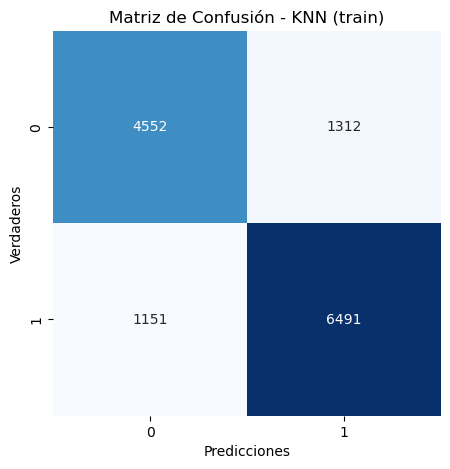

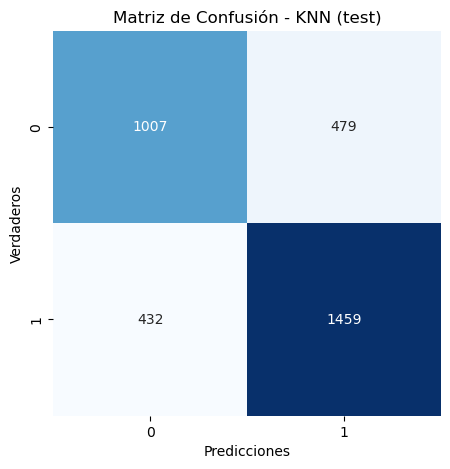

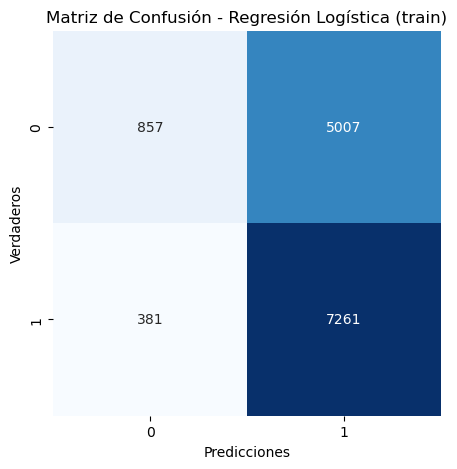

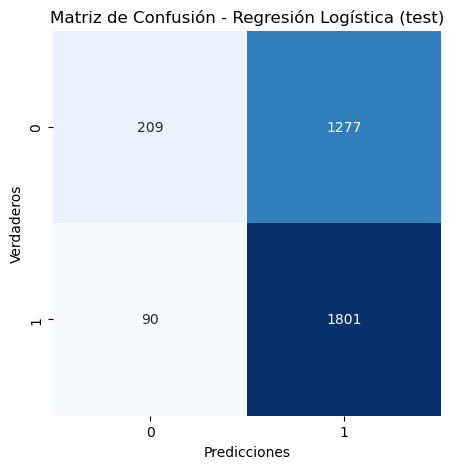

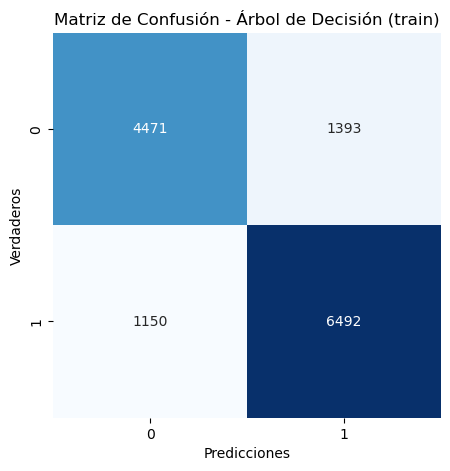

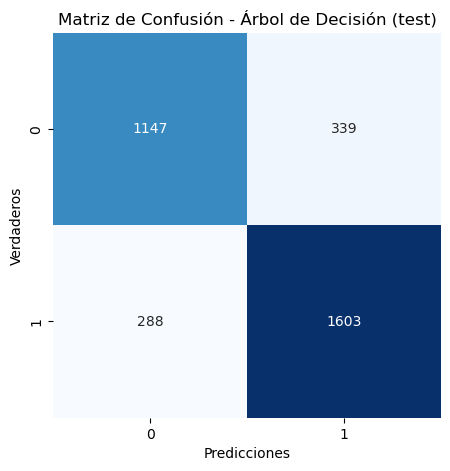

In [527]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir las probabilidades en predicciones binarias utilizando el umbral de 0.5
y_train_pred1 = (y_train_proba1 >= 0.5).astype(int)
y_test_pred1 = (y_test_proba1 >= 0.5).astype(int)

y_train_pred2 = (y_train_proba2 >= 0.5).astype(int)
y_test_pred2 = (y_test_proba2 >= 0.5).astype(int)

y_train_pred3 = (y_train_proba3 >= 0.5).astype(int)
y_test_pred3 = (y_test_proba3 >= 0.5).astype(int)

# Calcular la matriz de confusión para cada algoritmo
confusion_matrix_train1 = confusion_matrix(y_train, y_train_pred1)
confusion_matrix_test1 = confusion_matrix(y_test, y_test_pred1)

confusion_matrix_train2 = confusion_matrix(y_train, y_train_pred2)
confusion_matrix_test2 = confusion_matrix(y_test, y_test_pred2)

confusion_matrix_train3 = confusion_matrix(y_train, y_train_pred3)
confusion_matrix_test3 = confusion_matrix(y_test, y_test_pred3)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderos')
    plt.show()

# Mostrar la matriz de confusión para cada algoritmo
plot_confusion_matrix(confusion_matrix_train1, "Matriz de Confusión - KNN (train)")
plot_confusion_matrix(confusion_matrix_test1, "Matriz de Confusión - KNN (test)")

plot_confusion_matrix(confusion_matrix_train2, "Matriz de Confusión - Regresión Logística (train)")
plot_confusion_matrix(confusion_matrix_test2, "Matriz de Confusión - Regresión Logística (test)")

plot_confusion_matrix(confusion_matrix_train3, "Matriz de Confusión - Árbol de Decisión (train)")
plot_confusion_matrix(confusion_matrix_test3, "Matriz de Confusión - Árbol de Decisión (test)")


### 10 - Metricas
- Calcular Recall
- Calcular Precision 
- Calcular F1-Score 
- Calcular curva ROC - AUC

In [528]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

# Métricas para el modelo 1 - KNN
print("Modelo 1 - Regresión Logística")
print(" Recall:", round(recall_score(y_test, y_test_pred1)*100,2))
print(" Precisión:", round(precision_score(y_test, y_test_pred1)*100,2))
print(" F1-Score:", round(f1_score(y_test, y_test_pred1)*100,2))
print(" AUC-ROC:", round(roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])*100,2))
print()

# Métricas para el modelo 2 - Regresión Logística
print("Modelo 2 - Árbol de Decisión")
print(" Recall:", round(recall_score(y_test, y_test_pred2)*100,2))
print(" Precisión:", round(precision_score(y_test, y_test_pred2)*100,2))
print(" F1-Score:", round(f1_score(y_test, y_test_pred2)*100,2))
print(" AUC-ROC:", round(roc_auc_score(y_test, lg_model.predict_proba(X_test)[:, 1])*100,2))
print()

# Métricas para el modelo 3 - Árbol de Decisión
print("Modelo 3 - Random Forest")
print(" Recall:", round(recall_score(y_test, y_test_pred3)*100,2))
print(" Precisión:", round(precision_score(y_test, y_test_pred3)*100,2))
print(" F1-Score:", round(f1_score(y_test, y_test_pred3)*100,2))
print(" AUC-ROC:", round(roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])*100,2))


Modelo 1 - Regresión Logística
 Recall: 77.15
 Precisión: 75.28
 F1-Score: 76.21
 AUC-ROC: 79.26

Modelo 2 - Árbol de Decisión
 Recall: 95.24
 Precisión: 58.51
 F1-Score: 72.49
 AUC-ROC: 58.56

Modelo 3 - Random Forest
 Recall: 84.77
 Precisión: 82.54
 F1-Score: 83.64
 AUC-ROC: 88.36


### 11 - Conclusiones
¿Con que eficacia podemos encontrar las oportunidades?

Modelo 1 (kNN):
- Mayor precisión en el conjunto de entrenamiento (0.82) que en el conjunto de prueba (0.73), lo que indica un posible sobreajuste.
- Buen rendimiento en ROC-AUC tanto en el conjunto de entrenamiento (0.90) como en el conjunto de prueba (0.79), aunque hay una diferencia entre ambos indicadores, lo que sugiere una generalización aceptable.
- Equilibrio razonable entre Precisión y Recall, lo que indica que es capaz de identificar correctamente tanto las instancias positivas como las negativas.

Modelo 2 (Regresión Logística):
- Precisión similar en el conjunto de entrenamiento (0.60) y en el conjunto de prueba (0.60), lo que sugiere que el modelo no muestra signos de sobreajuste.
- Bajo rendimiento en ROC-AUC tanto en el conjunto de entrenamiento (0.58) como en el conjunto de prueba (0.59), lo que indica dificultades para discriminar entre clases.
- Alta Recall, lo que sugiere que es bueno identificando instancias positivas, pero una baja Precisión, lo que indica que puede tener muchos falsos positivos.

Modelo 3 (Árbol de Decisión):
- Alta precisión tanto en el conjunto de entrenamiento (0.81) como en el conjunto de prueba (0.81), lo que sugiere un buen rendimiento y generalización.
- Alto rendimiento en ROC-AUC tanto en el conjunto de entrenamiento (0.89) como en el conjunto de prueba (0.88), lo que indica una buena capacidad de generalización.
- Alta Recall y una Precisión razonable, lo que sugiere un buen equilibrio entre identificar instancias positivas y minimizar falsos positivos.

Basándonos en el indicador de "predecir la probabilidad de éxito" para el caso de "Frío Frío", el mejor modelo sería el Modelo 3, que es el Árbol de Decisión.

El Modelo 3 (Árbol de Decisión) mostró el mejor rendimiento en términos de precisión, tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que indica que tiene la capacidad de predecir con mayor precisión la probabilidad de éxito de cada oportunidad comercial.

Además, el Modelo 3 obtuvo una alta área bajo la curva ROC (AUC-ROC) tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que significa que el modelo puede discriminar de manera efectiva entre las oportunidades que se convertirán en ventas exitosas y aquellas que no lo harán.

El hecho de que el Modelo 3 tenga un equilibrio razonable entre Recall y Precisión sugiere que es capaz de identificar correctamente tanto las oportunidades comerciales exitosas como las no exitosas, minimizando los falsos positivos y falsos negativos. Este modelo tiene una alta precisión y una buena capacidad de discriminación, lo que lo hace confiable para ayudar a optimizar los esfuerzos de los representantes comerciales y mejorar el rendimiento general de la empresa en la venta e instalación de equipos de aire acondicionado para grandes superficies.